In [111]:
import torch
import torch.nn as nn
from torch.nn.functional import relu, sigmoid, conv2d, dropout, max_pool2d
from torch.utils.data import random_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [112]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: True 


### Loading Mnist images

In [ ]:
mnist_dataset = datasets.MNIST(
    root = 'data/',
    train = True,
    transform = transforms.ToTensor(),
    download=True
)

In [5]:
mnist_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: data/
    Split: Train
    StandardTransform
Transform: ToTensor()

In [6]:
train_data, validation_data = random_split(mnist_dataset, [50000, 10000])

In [110]:
batch_size = 128
train_loader = DataLoader(train_data, batch_size, shuffle = True)
val_loader = DataLoader(validation_data, batch_size, shuffle = False)

# Model

In [120]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2d_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 64)
        self.fc2 = nn.Linear(64, 10)

        self.dropout = nn.Dropout(p=0.2)
        self.sigmoid = sigmoid

    def forward(self, x):
        x = relu(max_pool2d(self.conv1(x), 2))
        x = relu(max_pool2d(self.conv2(x), 2))
        x = self.conv2d_drop(x)
        x = x.view(-1, 320)
        x = relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [121]:
model = CNN().to(device)
criterion  = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [122]:
epochs = 25
train_losses, val_losses = [], []

for e in range(epochs):
    running_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        log_ps = model(images)
        loss = criterion(log_ps, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    test_loss = 0
    accuracy = 0

    with torch.no_grad():
        model.eval()
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            log_ps = model(images)
            test_loss += criterion(log_ps, labels)

            ps = torch.exp(log_ps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor))

    model.train()

    train_losses.append(running_loss / len(train_loader))
    val_losses.append(test_loss / len(val_loader))

    print(f"Epoch: {e+1}/{epochs} ",
          f"Training Loss: {train_losses[-1]:.3f} ",
          f"Test Loss: {val_losses[-1]:.3f} ",
          f"Test Accuracy: {accuracy / len(val_loader):.3f}")


Epoch: 1/25  Training Loss: 1.476  Test Loss: 0.551  Test Accuracy: 0.856
Epoch: 2/25  Training Loss: 0.495  Test Loss: 0.362  Test Accuracy: 0.896
Epoch: 3/25  Training Loss: 0.382  Test Loss: 0.299  Test Accuracy: 0.912
Epoch: 4/25  Training Loss: 0.330  Test Loss: 0.260  Test Accuracy: 0.924
Epoch: 5/25  Training Loss: 0.292  Test Loss: 0.233  Test Accuracy: 0.930
Epoch: 6/25  Training Loss: 0.263  Test Loss: 0.204  Test Accuracy: 0.939
Epoch: 7/25  Training Loss: 0.241  Test Loss: 0.186  Test Accuracy: 0.947
Epoch: 8/25  Training Loss: 0.221  Test Loss: 0.171  Test Accuracy: 0.952
Epoch: 9/25  Training Loss: 0.206  Test Loss: 0.158  Test Accuracy: 0.953
Epoch: 10/25  Training Loss: 0.194  Test Loss: 0.147  Test Accuracy: 0.957
Epoch: 11/25  Training Loss: 0.181  Test Loss: 0.138  Test Accuracy: 0.960
Epoch: 12/25  Training Loss: 0.176  Test Loss: 0.129  Test Accuracy: 0.962
Epoch: 13/25  Training Loss: 0.168  Test Loss: 0.125  Test Accuracy: 0.964
Epoch: 14/25  Training Loss: 0.159

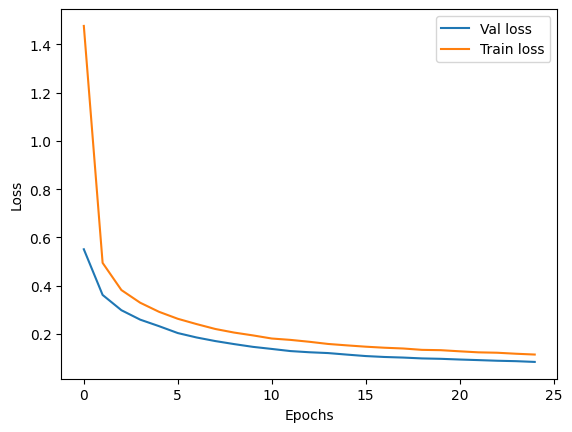

In [124]:
plt.plot(val_losses, label="Val loss")
plt.plot(train_losses, label="Train loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()